In [1]:
import os
#import re
import sys
#import json
import glob
import random
#import pickle
import subprocess
from datetime import datetime
from collections import Counter
from joblib import Parallel, delayed

import numpy as np
import pandas as pd

from nltk.corpus import stopwords as sw

import matplotlib.pyplot as plt
#import scikitplot.plotters as skplt
#from sklearn import metrics

from pynlpl.formats import folia

# Customs
#import get_folia_tokens as gft

%matplotlib inline

In [2]:
def getAnnotatedDocs(inputfolder='../EIFD/data/EIFD-FlatData', foliaset='https://raw.githubusercontent.com/ErkanBasar/mebasarcom/master/eifd.foliaset.xml'):
    return [xfile for xfile in glob.glob(inputfolder +'/*.folia.xml') if folia.Document(file=xfile).declared(folia.Entity, foliaset)]

In [3]:
mbt_folder = 'data/MBTData/'
mbt_cv_folder = mbt_folder + 'Cross-validated/'

In [4]:
annotdocs = getAnnotatedDocs()

## Feature Extraction

In [5]:
notstop = ['this', 'until', 'about', 'above' , 'over' , 'under' , 'more', 'some', 'few', 'than', 'now', 'at']
stopwords = [word for word in sw.words('english') if word not in notstop]
#ignored = ['dmg.ppl.inj', 'dmg.ppl.miss', 'dmg.bus', 'dmg.econ', 'loc.other']

In [6]:
class Token(object):
    
    def __init__(self, folia_obj):
        self.obj = folia_obj
        self.cls = 'O'
        self.ner = '---'
        self.previous = None
        self.next = None
        if(self.obj is None):
            self.foliaId = '---'
            self.text = '---'
            self.pos = '---'
        else:
            self.foliaId = self.obj.id
            self.text = self.obj.text()
            self.pos = self.obj.pos()

    def getClass(self, classes):
        if(self.obj is not None):
            for entity in self.obj.findspans(folia.Entity):
                if(entity.annotatortype == folia.AnnotatorType.MANUAL):
                    if(entity.cls in classes):
                        if(entity.cls == 'loc.other'):
                            entityclass = 'loc.focus' 
                        else:
                            entityclass = entity.cls 
                        self.cls = 'B.' + entityclass
                        if(self.previous == None):
                            self.cls = 'B.' + entityclass 
                        else:
                            for prevEntity in self.previous.findspans(folia.Entity):
                                if(entity.id == prevEntity.id and prevEntity.annotatortype == folia.AnnotatorType.MANUAL):
                                    self.cls = 'I.' + entityclass
        return self.cls
    
    def getNer(self):
        if(self.obj is not None):
            for entity in self.obj.findspans(folia.Entity):
                if(entity.annotator == 'nltk-stanford'):
                    self.ner = entity.cls
        return self.ner
    
    def getPrevious(self):
        if self.obj is not None and self.obj.previous(folia.Word, [folia.Sentence]) is not None:
            self.previous = self.obj.previous(folia.Word, [folia.Sentence])
        return self.previous
    
    def getNext(self):
        if self.obj is not None and self.obj.next(folia.Word, [folia.Sentence]) is not None:
            self.next = self.obj.next(folia.Word, [folia.Sentence])
        return self.next
    
    def kill(self):
        del self

In [7]:
def create_line(token, classes):
    prevToken = Token(token.getPrevious())
    line = token.text + ' ' + token.pos + ' ' + token.getNer() + ' '
    line = line + str(token.getClass(classes)) + '\n'
    return line

In [8]:
def create_mbt_file(filelist, outfilepath, classes):
    filelist = [filelist] if(type(filelist) == str) else filelist
    if(type(filelist) == list and len(filelist) >= 1):
        outfile = open(outfilepath, 'w')
        for filepath in filelist:
            for doc in folia.Document(file=filepath):
                for sentence in doc.sentences():
                    for word in sentence.words():
                        token = Token(word)
                        outfile.write(create_line(token, classes))
                    outfile.write('<utt>\n')
        outfile.close()
    else:
        print('Input may be wrong. It should be a list of file paths or a single string file path.')
        print('Input type you tried: ' + str(type(filelist)))
        sys.exit()

# Article Cross-validater

In [9]:
def get_cv_chunks(doclist, n, shuffle=True):
    if(shuffle):
        random.shuffle(doclist)
    return [doclist[i:i + n] for i in range(0, len(doclist), n)]

In [10]:
def create_cv_files(cv_label_folder, cv_chunks, doclist, classes):
    Parallel(n_jobs=-2)(delayed(split_per_chunk)(cv_label_folder, classes, doclist, testdocs, i) for i, testdocs in enumerate(cv_chunks))

In [11]:
def split_per_chunk(cv_label_folder, classes, doclist, testdocs, i):
    traindocs = [doc for doc in doclist if doc not in testdocs]
    os.makedirs(os.path.dirname(cv_label_folder + '/CV_' + str(i) + '/'), exist_ok=True)
    create_mbt_file(traindocs, cv_label_folder + '/CV_' + str(i) + '/MBTTrain_cv' + str(i) + '.data', classes)
    create_mbt_file(testdocs, cv_label_folder + '/CV_' + str(i) + '/MBTTest_cv' + str(i) + '.data', classes)

## Run MBT

In [12]:
def run_mbt(cv_label_folder, known_words='dwdwfWawaw', unknown_words='cndwdwFawaw'):
    Parallel(n_jobs=-2)(delayed(run_on_single_chunk)(cv_label_folder, label_folder, known_words, unknown_words) for label_folder in glob.glob(cv_label_folder +'/CV_*'))

In [13]:
def run_on_single_chunk(cv_label_folder, label_folder, known_words='dwdwfWawaw', unknown_words='cndwdwFawaw'):
    i = label_folder.split('CV_')[1]
    p = subprocess.Popen(['mbtg', '-E', 'MBTTrain_cv' + str(i) + '.data', '-p', known_words, '-P', unknown_words], 
                         cwd=cv_label_folder + '/CV_' + str(i) + '/')
    p.wait()
    testOut = open(cv_label_folder + '/CV_' + str(i) + '/test_cv' + str(i) + '.out', 'w') 
    p = subprocess.Popen(['mbt', '-s', 'MBTTrain_cv' + str(i) + '.data.settings', '-E','MBTTest_cv' + str(i) + '.data'], 
                         stdout=testOut, cwd=cv_label_folder + '/CV_' + str(i) + '/')
    p.wait()

# Evaluation

In [26]:
def conll_tag(tag):
    if(tag is not 'O'):
        tagsplt = tag.split('.')
        IOB = tagsplt[0]
        del tagsplt[0]
        rest = '_'.join(tagsplt)
        tag = IOB + '-' + rest
    return tag

In [15]:
def merged_cv_evaluation(cv_label_folder):
    outfile = open(cv_label_folder + '/test.out', 'w')
    for label_folder in glob.glob(cv_label_folder +'/CV_*'):
        i = label_folder.split('CV_')[1]
        testOut = open(label_folder + '/test_cv' + str(i) + '.out', 'r')
        outcv = open(label_folder + '/testconll_cv' + str(i) + '.out', 'w')
        lines = testOut.readlines()
        for line in lines[7:]:
            spacesplt = line.split('\n')[0]
            tabsplt = spacesplt.split('\t')
            Y = tabsplt[-2]
            P = tabsplt[-1]
            if(len(tabsplt) > 1):
                line = tabsplt[0] + ' ' + conll_tag(Y) + ' ' + conll_tag(P) + '\n'
                outcv.write(line)
                outfile.write(line)
            else:
                outcv.write('\n')
                outfile.write('\n')
        outcv.close()        
        testOut.close()
        outfile.write('\n')
    outfile.close()
    os.system('perl conlleval.pl <' + cv_label_folder + '/test.out >' + cv_label_folder + '/eval.out')

In [16]:
def get_eval_scores(cv_label_folder):
    testeval = open(cv_label_folder + '/eval.out', 'r')
    scores = {}
    for line in testeval:
        info = list(filter(lambda a: a != '', line.split(' ')))
        if('processed' in info):
            continue
        elif('accuracy:' in info):
            scores['average'] = {}
            scores['average']['accuracy'] = float(info[1].split('%')[0])
            scores['average']['precision'] = float(info[3].split('%')[0])
            scores['average']['recall'] = float(info[5].split('%')[0])
            scores['average']['f1-score'] = float(info[7].split('\n')[0])
        else:
            label = info[0].split(':')[0]
            scores[label] = {}
            scores[label]['precision'] = float(info[2].split('%')[0])
            scores[label]['recall'] = float(info[4].split('%')[0])
            scores[label]['f1-score'] = float(info[6])
            scores[label]['support'] = int(info[7].split('\n')[0])
    return scores

In [31]:
def draw_prf1_bar(scores):
    precision = []
    recall = []
    f1_score = []
    labels = []
    for s in scores.items():
        labels.append(s[0])
        precision.append(s[1]['precision'])
        recall.append(s[1]['recall'])
        f1_score.append(s[1]['f1-score'])
    index = np.arange(len(labels))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    bar_width = 0.25
    opacity = 0.75
    ax.bar(index, precision, bar_width, color='b', label='Precision')
    ax.bar(index + bar_width, recall, bar_width, color='m', label='Recall', alpha=opacity)
    ax.bar(index + (2*bar_width), f1_score, bar_width, color='c', label='F1-score', alpha=opacity)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labels, rotation=75)
    ax.legend()
    plt.xlabel('Labels')
    plt.ylabel('Scores')
    plt.title('Scores by Label')
    plt.show()

# Main

In [32]:
def main(cv_label_folder, cv_chunks, doclist, classes):
    create_cv_files(cv_label_folder, cv_chunks, doclist, classes)
    run_mbt(cv_label_folder)
    merged_cv_evaluation(cv_label_folder)

# Initialize Chunks

In [33]:
cv_chunks = get_cv_chunks(annotdocs, 1)

# 4 Major Classes

In [34]:
major_classes = ['event.flood', 'loc.focus', 'loc.supp', 'time']

In [35]:
main(mbt_cv_folder + 'major_classes', cv_chunks, annotdocs, major_classes)

In [36]:
scores_major = get_eval_scores(mbt_cv_folder + 'major_classes')

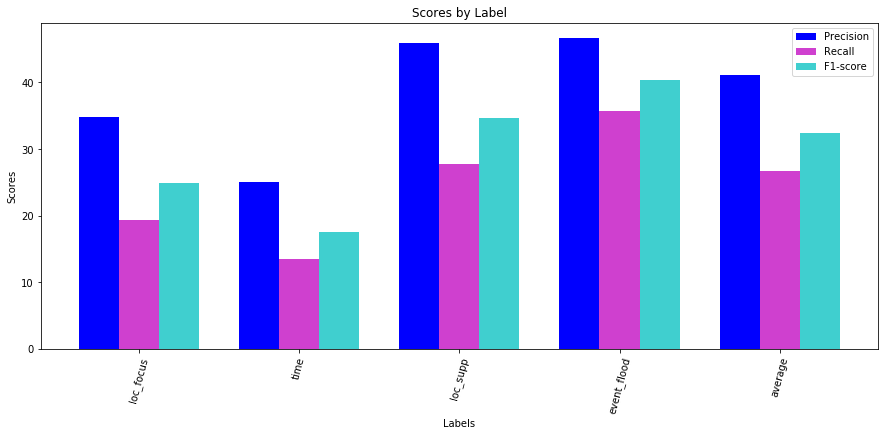

In [37]:
# leave one out
draw_prf1_bar(scores_major)

# All Classes

In [140]:
all_classes = ['event.flood', 'loc.focus', 'loc.supp', 'time', 'dmg.ppl.evac', 'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']

In [141]:
main(mbt_cv_folder + 'all_classes', cv_chunks, annotdocs, all_classes)

In [39]:
scores_all = get_eval_scores(mbt_cv_folder + 'all_classes')

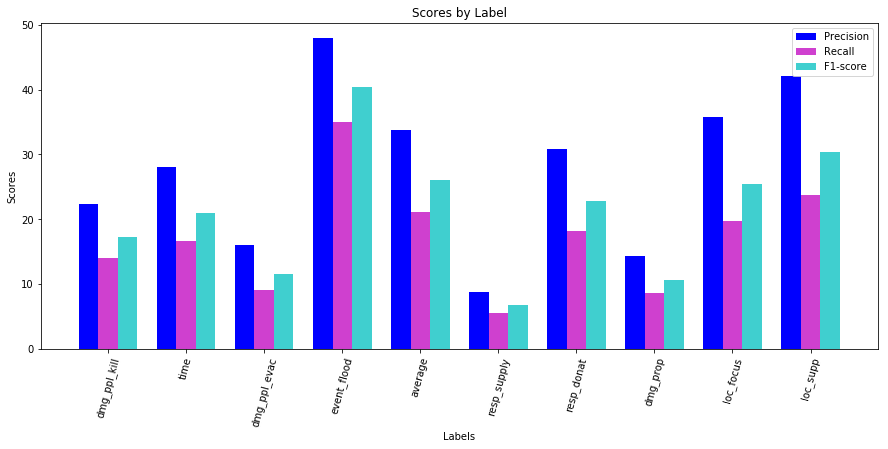

In [40]:
# leave one out
draw_prf1_bar(scores_all)

# Binary Classifiers 

In [19]:
binary_classes = ['event.flood', 'loc.focus', 'loc.supp', 'time', 'dmg.ppl.evac', 'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']

In [159]:
for cls in binary_classes:
    main(mbt_cv_folder + 'Binaries/' + cls, cv_chunks, annotdocs, [cls])

In [27]:
scores_binary = {}
for cls in binary_classes:
    scores_binary[cls] = get_eval_scores(mbt_cv_folder + 'Binaries/' + cls)['_'.join(cls.split('.'))]

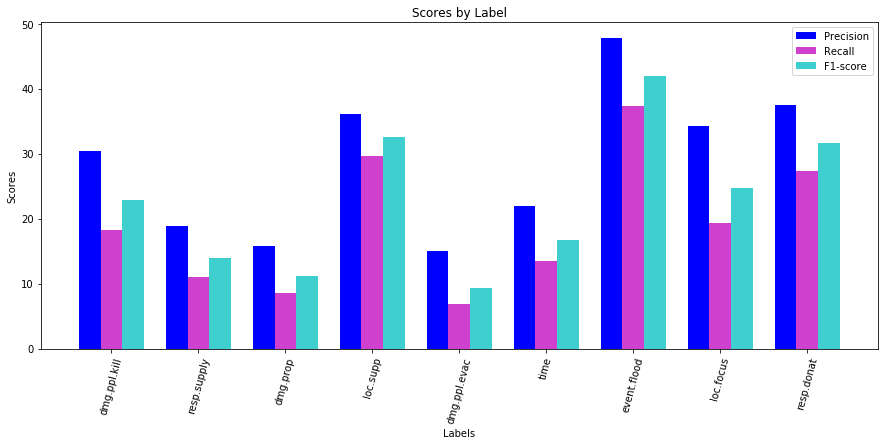

In [23]:
# leave one out
draw_prf1_bar(scores_binary)